In [3]:
%load_ext autoreload
%autoreload 2

In [329]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo
import statsmodels.api as sm
from scipy.optimize import curve_fit
import ratingcurve

In [5]:
import preprocessing as preproc

# Data Collection & Preprocessing

In [8]:
def convert_ft_to_m(df, col, new_col=None):
    """
    Convert a column from feet to meters (in‚Äëplace, no return).
    """
    factor = 0.3048
    df[new_col or col] = df[col] * factor
    # no return ‚Üí implicitly returns None


In [10]:
def convert_cfs_to_m3s(df, col, new_col=None):
    """
    Convert a column from cfs to m¬≥/s (in‚Äëplace, no return).
    """
    factor = 0.0283168
    df[new_col or col] = df[col] * factor

## USGS Data Collection

In [13]:
int_freq = 60 # hourly interval

In [15]:
start_date = '2022-01-01'
end_date = '2024-12-31'
date_range = preproc.create_date_range(start_date, end_date)

In [17]:
inflow_site = '14128600'

## Collect Dataset #1
df1 = preproc.preprocess(inflow_site, int_freq, start_date, end_date)

COLUMBIA RIVER AT STEVENSON, WA
Removed 3 duplicate rows

Removed 0 rows with NaN in '00065'

Imputed 3 rows


In [18]:
outflow_site = '14105700'

## Collect Dataset #2
# Note: Can update this to retrieve discharge data as well
df2 = preproc.preprocess(outflow_site, int_freq, start_date, end_date)

COLUMBIA RIVER AT THE DALLES, OR
Removed 3 duplicate rows

Removed 116 rows with NaN in '00065'

Imputed 119 rows


In [19]:
df_merge = df1.copy()
df_merge.rename(columns={'00065': 'inflow_ft'}, inplace=True)
# df_merge = df_merge.merge(df2, left_index=True, right_index=True, how='inner')
# df_merge.rename(columns={'00065': 'up_outflow'}, inplace=True)
# df_merge.drop(['site_no_x', 'site_no_y'], axis=1, inplace=True)
df_merge.drop(['site_no'], axis=1, inplace=True)
df_merge = df_merge.reset_index()

## USACE Data Collection

In [21]:
bon_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/bonneville/"
tda_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/dalles/"

In [22]:
## Load Bonneville Data
# Manually fixing timezone + extra datapoint

bon_hourly = pd.read_csv(bon_path + "bon-hourlyops.csv")
bon_hourly['Date Time'] = pd.to_datetime(bon_hourly['Date Time'])
bon_hourly['Date Time'] = bon_hourly['Date Time'] + pd.Timedelta(hours=3)
bon_hourly = bon_hourly.iloc[1:].reset_index(drop=True)

In [23]:
len(bon_hourly)

26303

In [24]:
bon_hourly.columns

Index(['Date Time', 'BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]',
       'BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]',
       'BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]',
       'BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]'],
      dtype='object')

In [25]:
bon = bon_hourly.copy()
bon = bon.rename(columns={"BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]": 'inflow_kcfs'})
bon = bon.rename(columns={'BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]': 'forebay_ft'})
bon = bon.rename(columns={"Date Time": 'datetime'})
bon = bon[['datetime', 'inflow_kcfs', 'forebay_ft']]

In [26]:
bon.dropna(inplace = True)

In [27]:
bon.head()

datetime  inflow_kcfs  forebay_ft
1  2022-01-01 01:00:00      185.840        74.2
7  2022-01-01 07:00:00      189.168        74.1
13 2022-01-01 13:00:00      190.632        73.8
19 2022-01-01 19:00:00      191.640        73.9
25 2022-01-02 01:00:00      187.081        74.4

### Inflow Height Histograms

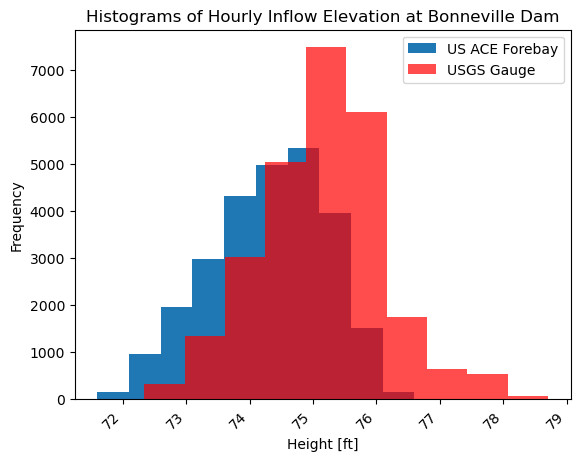

In [29]:
plt.hist(bon_hourly['BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]'], label = "US ACE Forebay")
plt.hist(df_merge.inflow_ft, alpha=.7, color="red", label = "USGS Gauge")
plt.title('Histograms of Hourly Inflow Elevation at Bonneville Dam')
plt.ylabel('Frequency')
plt.xlabel('Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

### Merge Datasets

In [31]:
df_merge = df_merge.merge(bon, on="datetime", how='inner')

In [32]:
df_merge.head()

datetime  inflow_ft  inflow_kcfs  forebay_ft
0 2022-01-01 01:00:00      75.34      185.840        74.2
1 2022-01-01 07:00:00      74.82      189.168        74.1
2 2022-01-01 13:00:00      75.13      190.632        73.8
3 2022-01-01 19:00:00      75.11      191.640        73.9
4 2022-01-02 01:00:00      75.28      187.081        74.4

In [33]:
len(df_merge)

4383

In [34]:
df_merge.isna().sum()

datetime       0
inflow_ft      0
inflow_kcfs    0
forebay_ft     0
dtype: int64

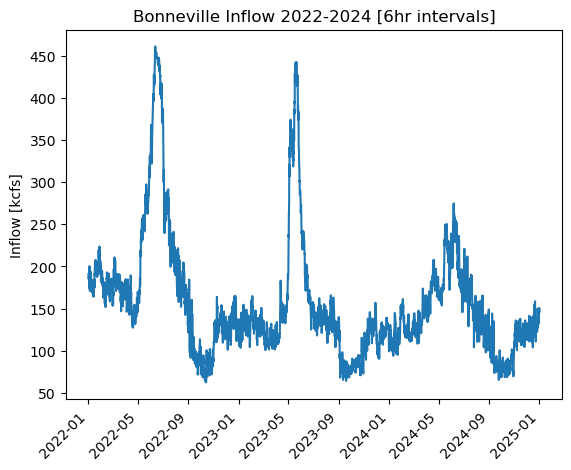

In [36]:
plt.plot(df_merge['datetime'], df_merge['inflow_kcfs'])
plt.title('Bonneville Inflow 2022-2024 [6hr intervals]')
plt.ylabel('Inflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

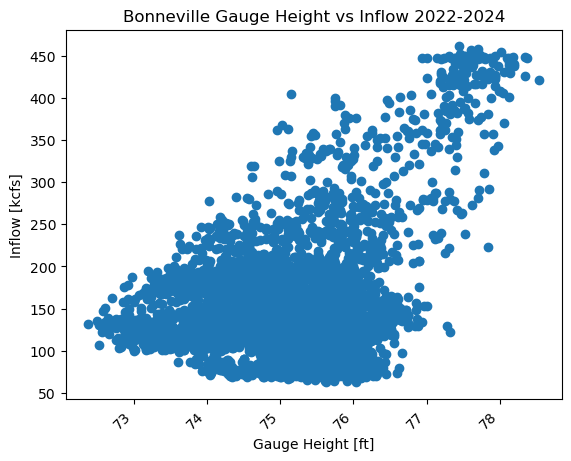

In [37]:
plt.scatter(df_merge.inflow_ft, df_merge.inflow_kcfs)
plt.title('Bonneville Gauge Height vs Inflow 2022-2024')
plt.ylabel('Inflow [kcfs]')
plt.xlabel('Gauge Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.show()

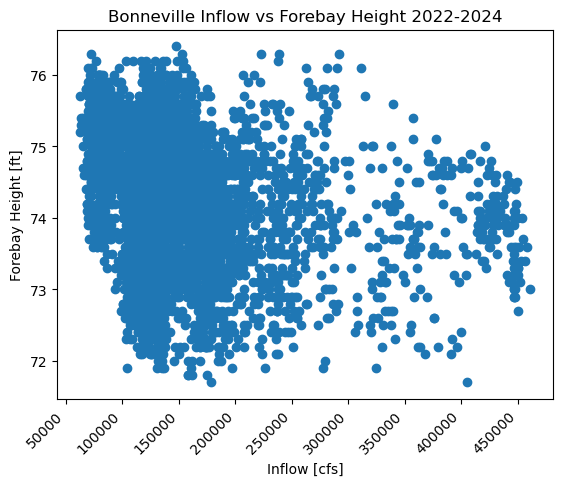

In [551]:
plt.scatter(df_merge.inflow_kcfs*1000, df_merge.forebay_ft)
plt.title('Bonneville Inflow vs Forebay Height 2022-2024')
plt.xlabel('Inflow [cfs]')
plt.ylabel('Forebay Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.show()

# Streamflow Rating Curve

### Bonneville Tailwater Streamflow Rating Curve Data

In [295]:
## Bonneville Tailwater Data

df3 = pd.read_csv(bon_path + "plot-data.csv")
df3 = df3.rename(columns={' y': 'h_ft'})
df3 = df3.rename(columns={'x': 'q_cfs'})

In [297]:
# Convert and add new columns
convert_ft_to_m(df3, "h_ft", "h_m")
convert_cfs_to_m3s(df3, "q_cfs", "q")

In [446]:
## Detrend the height data

# min(h) = 2.5 m

h0 = 0.547 # Estimated stage at zero flow
#h0 = min(df3.h_m) + 0.001
df3["h_eff"] = df3.h_m - h0 

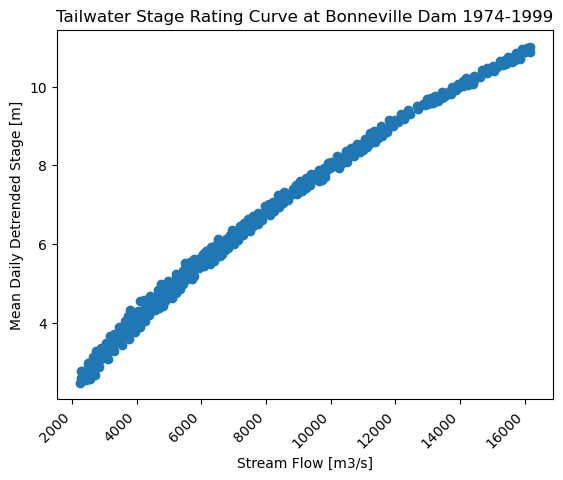

In [448]:
plt.scatter(df3.q, df3.h_m)
plt.title('Tailwater Stage Rating Curve at Bonneville Dam 1974-1999')
plt.xlabel('Stream Flow [m3/s]')
plt.ylabel('Mean Daily Detrended Stage [m]')
plt.xticks(rotation=45, ha='right')
plt.show()

In [433]:
## Bonneville Tailwater Data
# q: inflow (m3/s)
# h: tailwater height (m) 

df3.head()

q_cfs      h_ft       h_m            q     h_eff
0   80611.505839  8.583172  2.616151  2282.659889 -0.378132
1   85026.126669  8.851974  2.698082  2407.667824 -0.296202
2   90648.646001  9.206493  2.806139  2566.879579 -0.188144
3   95887.285262  9.561012  2.914197  2715.221079 -0.080087
4  100477.299573  9.944381  3.031047  2845.195597  0.036764

## Estimating the Bonneville Tailwater Streamflow Rating Curve

In [450]:
## Log Linear OLS

X = sm.add_constant(np.log(df3["h_eff"]))     # adds intercept = log‚ÄØa
y = np.log(df3["q"])

ols = sm.OLS(y, X).fit()
log_a, b = ols.params
a = np.exp(log_a)

print(f"OLS result:  a = {a:.4g},  b = {b:.4g}")

OLS result:  a = 856.5,  b = 1.228


In [452]:
## Nonlinear Least Sqaures

def rating(h, a, b):
    return a * (h - h0)**b

p0 = (df3["q"].median() / df3["h_eff"].median(), 1.5)  # simple starting guess
pars, cov = curve_fit(rating, df3["h_m"], df3["q"], p0=p0)
a_nls, b_nls = pars

print(f"NLS result:  a = {a_nls:.4g},  b = {b_nls:.4g}")

NLS result:  a = 731.7,  b = 1.31


In [454]:
def predict_flow(h_val, a, b, h0_val):
    return a * (h_val-h0_val)**b

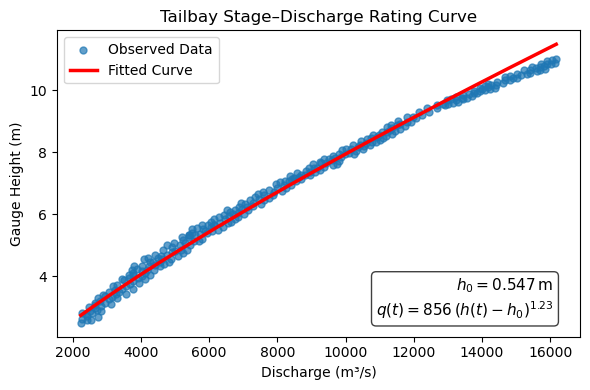

In [458]:
# ----------  Values from the fit  ----------
a_disp  = a     
b_disp  = b
h0_disp = h0

# ----------  Build the plot  ----------
fig, ax = plt.subplots(figsize=(6, 4))

# 1. Scatter: observed data (x = q, y = h)
ax.scatter(df3["q"], df3["h_m"], s=25, alpha=0.7, label="Observed Data")

# 2. Fitted curve (plot h(q))
q_line = np.linspace(df3["q"].min(), df3["q"].max(), 400)
h_line = h0_disp + (q_line / a_disp)**(1 / b_disp)
ax.plot(q_line, h_line, lw=2.5, label="Fitted Curve",color='r')

# 3. Multiline label in the bottom‚Äëright corner
label_text = (
    rf"$h_0 = {h0_disp:.3g}\,\mathrm{{m}}$" "\n"
    rf"$q(t) = {a_disp:.3g}\,(h(t) - h_0)^{{{b_disp:.3g}}}$"
)

ax.text(
    0.95, 0.05,            # bottom‚Äëright in axes coords
    label_text,
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=11, fontweight="bold",
    linespacing=1.3,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.75)
)

# 4. Axis labels & title
ax.set_xlabel("Discharge (m¬≥/s)")
ax.set_ylabel("Gauge Height (m)")
ax.set_title("Tailbay Stage‚ÄìDischarge Rating Curve")
ax.legend()
fig.tight_layout()
plt.show()


### Calculating Mean and Std from Inverse Streamflow Rating Curve on Tailbay Data

In [472]:
# Extract forecasted q values for tailbay

h = df3.h_m.copy() # Tailbay gauge height [m]
Q = df3.q.copy()   # Tailbay flow rates [m3/s]

Q_vals = predict_flow(h, a, b, h0)

In [470]:
mean_q,   std_q   = np.mean(Q),      np.std(Q,      ddof=1)   # ddof=1 ‚áí sample stdev
mean_q_tail, std_q_tail = np.mean(Q_vals), np.std(Q_vals, ddof=1)

In [474]:
print(
    f"Tailwater Flow Statistics (m3/s)\n"
    f"‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n"
    f"Observed   Q (Tailbay):  mean = {mean_q:8.2f}  |  stdev = {std_q:8.2f}\n"
    f"Forecasted Q (Tailbay):  mean = {mean_q_tail:8.2f}  |  stdev = {std_q_tail:8.2f}\n"
)

Tailwater Flow Statistics (m3/s)
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Observed   Q (Tailbay):  mean =  8368.24  |  stdev =  4034.89
Forecasted Q (Tailbay):  mean =  8327.72  |  stdev =  3847.79



### Calculating Mean and Std from Inverse Streamflow Rating Curve on Forebay Data

In [529]:
## Collecting Bonneville Forebay Data

h0_forebay = 21.336  # 70ft converted to meters, the minimum allowed forebay levels

df4 = df_merge[['datetime', 'inflow_kcfs', 'forebay_ft']].copy()
df4["inflow_cfs"] = df4["inflow_kcfs"] * 1000  # kcfs --> cfs
convert_ft_to_m(df4, "forebay_ft", "h_m")
convert_cfs_to_m3s(df4, "inflow_cfs", "q")
df4["h_eff"] = df4["h_m"] - h0_forebay

In [531]:
df4.head()

datetime  inflow_kcfs  forebay_ft  inflow_cfs       h_m  \
0 2022-01-01 01:00:00      185.840        74.2    185840.0  22.61616   
1 2022-01-01 07:00:00      189.168        74.1    189168.0  22.58568   
2 2022-01-01 13:00:00      190.632        73.8    190632.0  22.49424   
3 2022-01-01 19:00:00      191.640        73.9    191640.0  22.52472   
4 2022-01-02 01:00:00      187.081        74.4    187081.0  22.67712   

             q    h_eff  
0  5262.394112  1.28016  
1  5356.632422  1.24968  
2  5398.088218  1.15824  
3  5426.631552  1.18872  
4  5297.535261  1.34112

In [533]:
q_vals = predict_flow(df4.h_m, a, b, h0_forebay)

In [537]:
mean_q_foreobs, std_q_foreobs = np.mean(df4.q), np.std(df4.q, ddof=1)

In [539]:
mean_q_fore, std_q_fore = np.mean(q_vals), np.std(q_vals, ddof=1)

In [543]:
print(
    f"Flow Statistics (m3/s)\n"
    f"‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n"
    f"Observed   Q (Tailbay):  mean = {mean_q:8.2f}  |  stdev = {std_q:8.2f}\n"
    f"Forecasted Q (Tailbay):  mean = {mean_q_tail:8.2f}  |  stdev = {std_q_tail:8.2f}\n"
    f"Observed   Q (Forebay):  mean = {mean_q_foreobs:8.2f}  |  stdev = {std_q_foreobs:8.2f}\n"
    f"Forecasted Q (Forebay):  mean = {mean_q_fore:8.2f}  |  stdev = {std_q_fore:8.2f}"
)

Flow Statistics (m3/s)
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Observed   Q (Tailbay):  mean =  8368.24  |  stdev =  4034.89
Forecasted Q (Tailbay):  mean =  8327.72  |  stdev =  3847.79
Observed   Q (Forebay):  mean =  4448.77  |  stdev =  2054.39
Forecasted Q (Forebay):  mean =  1189.86  |  stdev =   309.23


### Mapping the Rating Curve Parameters to Match Observed Mean and Std

In [555]:
mu_source = q_vals.mean()
std_source = q_vals.std()

mu_target = mean_q_foreobs
std_target = std_q_foreobs

# Transformation parameters
beta = std_target / std_source
alpha = mu_target - beta * mu_source

# Apply transformation
q_adj = alpha + beta * q_vals

In [563]:
alpha

-3456.0448244570016

In [565]:
beta

6.643467492718398

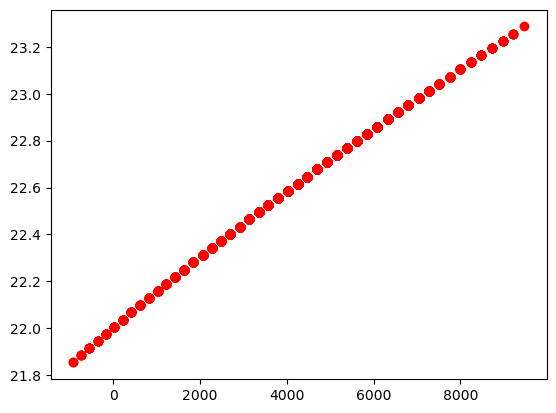

In [561]:
plt.scatter(q_adj, df4.h_m, color='r')
plt.show()

In [567]:
mean_q_adj, std_q_adj = np.mean(q_adj), np.std(q_adj, ddof=1)

In [575]:
print(
    f"Flow Statistics (m3/s)\n"
    f"‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n"
    f"Observed   Q (Tailbay):  mean = {mean_q:8.2f}  |  stdev = {std_q:8.2f}\n"
    f"Forecasted Q (Tailbay):  mean = {mean_q_tail:8.2f}  |  stdev = {std_q_tail:8.2f}\n"
    f"Observed   Q (Forebay):  mean = {mean_q_foreobs:8.2f}  |  stdev = {std_q_foreobs:8.2f}\n"
    f"Adjusted   Q (Forebay):  mean = {mean_q_adj:8.2f}  |  stdev = {std_q_adj:8.2f}"
)

Flow Statistics (m3/s)
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Observed   Q (Tailbay):  mean =  8368.24  |  stdev =  4034.89
Forecasted Q (Tailbay):  mean =  8327.72  |  stdev =  3847.79
Observed   Q (Forebay):  mean =  4448.77  |  stdev =  2054.39
Adjusted   Q (Forebay):  mean =  4448.77  |  stdev =  2054.39


## RatingCurve (Hodson et al 2024)
https://github.com/thodson-usgs/ratingcurve/blob/main/docs/notebooks/segmented-power-law-tutorial.ipynb

In [77]:
from ratingcurve.ratings import PowerLawRating
from ratingcurve import data
import pymc as pm
import arviz as az

In [170]:
# Discharge (q)
# Stage (h)
# Standard error of the discharge observations (e) - optional 

powerrating = PowerLawRating(segments=1,
                             prior={'distribution':'uniform'})

In [172]:
trace = powerrating.fit(q=df3['q'],
                        h=df3['h'],
                        q_sigma=None,
                        method='advi')

/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Convergence achieved at 61300
Interrupted at 61,299 [30%]: Average Loss = 5,793.1
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]


Output()

Sampling: [model_q]


Output()

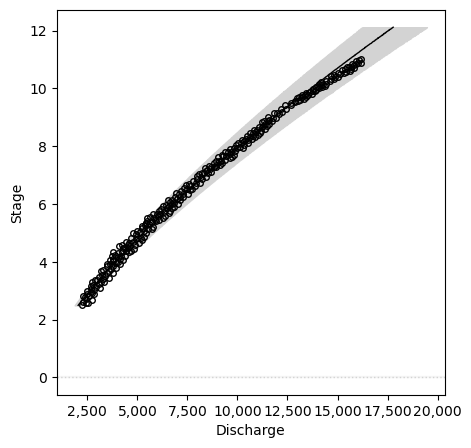

In [173]:
powerrating.plot()

In [174]:
table = powerrating.table()
table.head()

Sampling: [model_q]


Output()

stage    discharge       median       gse
0   2.49  2039.027257  2036.691497  1.047360
1   2.50  2050.113882  2046.359890  1.047491
2   2.51  2059.992512  2056.106685  1.047473
3   2.52  2071.900541  2069.059689  1.047398
4   2.53  2083.410993  2081.352781  1.047223

Sampling: [model_q]


Output()

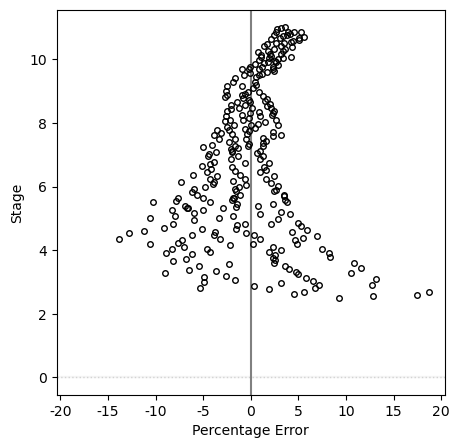

In [175]:
powerrating.plot_residuals()

In [180]:
print(trace.posterior.data_vars)

Data variables:
    b        (chain, draw, splines) float64 2.527 2.533 2.529 ... 2.53 2.53
    a        (chain, draw) float64 -4.678 -4.675 -4.677 ... -4.672 -4.667 -4.669
    sigma    (chain, draw) float64 0.08328 0.09128 0.08535 ... 0.08243 0.0821
    hs_      (chain, draw, hs__dim_0, hs__dim_1) float64 0.002566 ... 0.009608
    hs       (chain, draw, hs_dim_0, hs_dim_1) float64 0.002566 ... 0.009608
    X        (chain, draw, X_dim_0, X_dim_1) float64 0.9607 0.9916 ... 2.354


In [186]:
# The package author notes that USGS practice is simply to export a stage‚Äìdischarge table and not worry about the raw coefficients:

# Hystereis Analysis

## Correlation Analysis

### Autocorrelation Function (ACF)

The sample autocorrelation at lag \(k\):

$$
\rho_k \;=\;
\frac{\displaystyle \sum_{t=k+1}^{T}
        \left(y_t - \bar{y}\right)
        \left(y_{\,t-k} - \bar{y}\right)}
     {\displaystyle \sum_{t=1}^{T}
        \left(y_t - \bar{y}\right)^2}
$$


### Partial Autocorrelation Function (PACF)

Define \(\phi_{kk}\) as the coefficient on \(y_{t-k}\) when you regress
\(y_t\) on all intervening lags \(y_{t-1},\dots,y_{t-k}\):

$$
y_t \;=\;
\beta_1\,y_{t-1} \;+\;
\beta_2\,y_{t-2} \;+\;\dots+\;
\beta_k\,y_{t-k} \;+\;
\varepsilon_t.
$$

Then

$$
\phi_{kk} \;=\; \beta_k.
$$


In [328]:
h = df_merge[['inflow_ft']]
h.index = pd.to_datetime(df_merge.datetime)
q = df_merge.inflow_kcfs

In [363]:
h.head()

inflow_ft
datetime                      
2022-01-01 01:00:00      75.34
2022-01-01 07:00:00      74.82
2022-01-01 13:00:00      75.13
2022-01-01 19:00:00      75.11
2022-01-02 01:00:00      75.28

### Find the lag with the strongest (partial) autocorrelation
Try the ACF first; if you suspect higher-order structure, look at the PACF too.  
This helper returns the lag with the highest absolute value, skipping lag 0.

In [341]:
from statsmodels.tsa.stattools import acf, pacf

def strongest_lag(series, *, max_lag=96, method="acf"):
    if method == "acf":
        vals = acf(series, nlags=max_lag, fft=True, missing="drop")
    elif method == "pacf":
        vals = pacf(series, nlags=max_lag, method="ywm")
    else:
        raise ValueError("method must be 'acf' or 'pacf'")
    lag = 1 + np.argmax(np.abs(vals[1:]))  # +1 to offset lag-0
    return lag, vals[lag], vals

In [353]:
## Test acf

lag, rho, acf_vals = strongest_lag(h, max_lag=48, method="acf")
print(f"Strongest lag: {lag} steps  (œÅ = {rho:.3f})")


Strongest lag: 1 steps  (œÅ = 0.912)


In [355]:
## Test pacf

lag, rho, pacf_vals = strongest_lag(h, max_lag=48, method="pacf")
print(f"Strongest lag: {lag} steps  (œÅ = {rho:.3f})")

Strongest lag: 1 steps  (œÅ = 0.912)


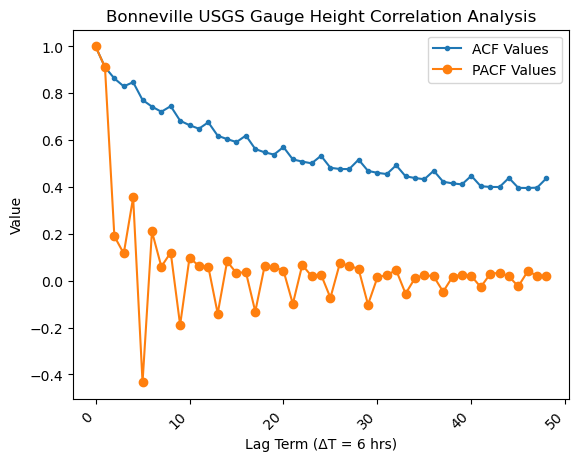

In [393]:
plt.plot(acf_vals, marker='o', markersize=3, label="ACF Values")
plt.plot(pacf_vals, marker='o', label = "PACF Values")
plt.title('Bonneville USGS Gauge Height Correlation Analysis')
plt.ylabel('Value')
plt.xlabel('Lag Term (ŒîT = 6 hrs)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

### Estimate $\hat{\beta}$ at Lag $k$

Let  

* $y_t$  be the original series  
* $y_{t-k}$  its value shifted back $k$ steps  
* $\hat{\beta}$  the coefficient we want to estimate  

We fit the one-lag regression

$$
y_t \;=\; \hat{\beta}\,y_{t-k} + \varepsilon_t ,
$$

and the ordinary-least-squares estimate is

$$
\hat{\beta} \;=\;
\frac{\displaystyle \sum_{t = k+1}^{T} y_t\,y_{t-k}}
     {\displaystyle \sum_{t = k+1}^{T} y_{t-k}^{\,2}} .
$$

This $\hat{\beta}$ captures the strength of the dominant hysteresis (memory) term at lag $k$.


In [429]:
col = "inflow_ft"

# y = original series as a Series
y = h[col].rename("y")         # Series, not DataFrame

# x = lagged version, kept as a Series too
x = h[col].shift(lag).rename("x")

# Combine and drop the NAs that the shift introduces
data = pd.concat([x, y], axis=1).dropna()

# Ordinary-least-squares estimate of Œ≤ÃÇ at that lag
beta = np.linalg.lstsq(data[["x"]], data["y"], rcond=None)[0][0]
print(f"lag {lag} ‚Üí Œ≤ÃÇ = {beta:.3f}")

lag 1 ‚Üí Œ≤ÃÇ = 1.000


### Remove the Dominant Hysteresis Term

Let:

- \( $y_t $\) be the original time series  
- \( $k$ \) be the dominant lag  
- \($ \hat{\beta}$ \) be the estimated AR coefficient at lag \( k \)

We compute the adjusted series \($ \tilde{y}_t $\) as:

\[
$\tilde{y}_t = y_t - \hat{\beta} \cdot y_{t-k}$
\]

This removes the contribution of the lag-\($k $\) memory term.



In [439]:
h_adj = y - beta * x

In [462]:
h_adj.head()

datetime
2022-01-01 01:00:00         NaN
2022-01-01 07:00:00   -0.518550
2022-01-01 13:00:00    0.311440
2022-01-01 19:00:00   -0.018554
2022-01-02 01:00:00    0.171446
dtype: float64

## Correlation for Whitened Gauge Height

### Validate the fix
* Plot the ACF/PACF again on h_adj ‚Äì the spike at lag should shrink.

* Run Ljung-Box or portmanteau tests to confirm remaining serial correlation is insignificant at operational lags.

* Back-test forecasts: does error (MAPE, RMSE) drop relative to the original series?

### Common pitfalls & cures
| Symptom                         | Likely cause                | Quick check            | Remedy                                                                |                   |                             |
| ------------------------------- | --------------------------- | ---------------------- | --------------------------------------------------------------------- | ----------------- | --------------------------- |
| Lag spikes every 48 or 96 steps | Diurnal/weekend seasonality | Plot daily ACF heatmap | Seasonal differencing or add Fourier terms                            |                   |                             |
| Two comparable peaks            | Bimodal inflow behaviour    | Box-plots by month     | Model separate regimes or use a State-Space/Markov-switching approach |                   |                             |
| Coefficient                     | Œ≤ÃÇ                          | ‚â• 1                    | Non-stationary (unit-root) process                                    | `adfuller()` test | First-difference the series |



Strongest lag: 4 steps  (œÅ = 0.531)


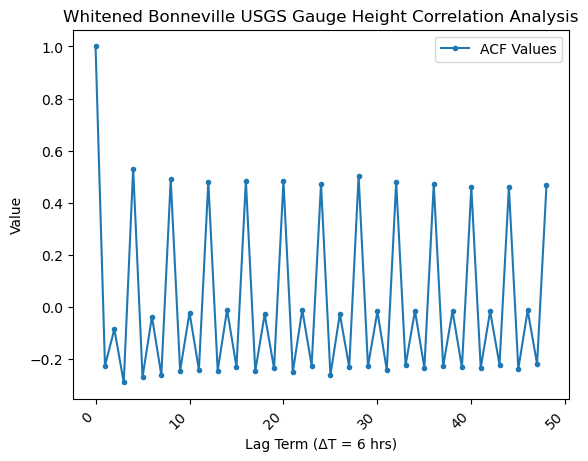

In [556]:
lag, rho, acf_vals = strongest_lag(h_adj, max_lag=48, method="acf")
print(f"Strongest lag: {lag} steps  (œÅ = {rho:.3f})")

#lag, rho, pacf_vals = strongest_lag(h_adj, max_lag=48, method="pacf")
#print(f"Strongest lag: {lag} steps  (œÅ = {rho:.3f})")

plt.plot(acf_vals, marker='o', markersize=3, label="ACF Values")
#plt.plot(pacf_vals, marker='o', label = "PACF Values")
plt.title('Whitened Bonneville USGS Gauge Height Correlation Analysis')
plt.ylabel('Value')
plt.xlabel('Lag Term (ŒîT = 6 hrs)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

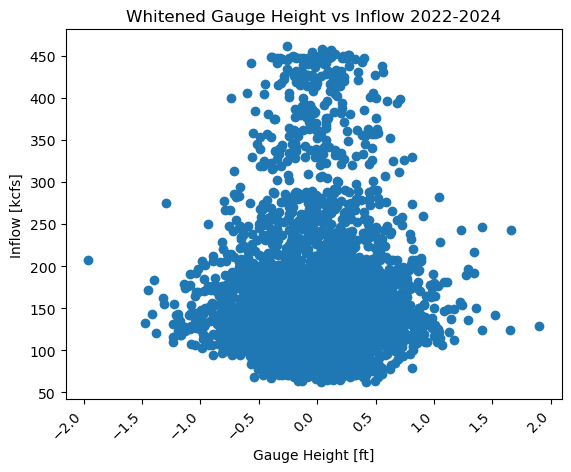

In [478]:
plt.scatter(h_adj, df_merge.inflow_kcfs)
plt.title('Whitened Gauge Height vs Inflow 2022-2024')
plt.ylabel('Inflow [kcfs]')
plt.xlabel('Gauge Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.show()

$$ \tilde{y}_t = y_t -  y_{t-1}$$

$\hat{\beta} = 1$ means a coefficient of exactly (or very nearly) 1 at lag 1 almost always means the series behaves like a random walk / unit-root process, i.e.

$$ y_t = y_{t-1} + \epsilon_t$$

| Implication                               | Why it happens                                                      | Typical next step                                                                                              |
| ----------------------------------------- | ------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **Non-stationary**                        | Variance grows with time; ACF decays very slowly.                   | *Difference* the series: $\nabla y_t = y_t - y_{t-1}$.                                                         |
| **AR coefficient estimates max out at 1** | OLS can‚Äôt go above 1 because the best fit is ‚Äúcopy the last value.‚Äù | Run a unit-root test (e.g. Augmented Dickey‚ÄìFuller) to confirm; then model the *differences* with ARMA/GARCH/‚Ä¶ |


<Axes: title={'center': 'First difference'}, xlabel='datetime'>

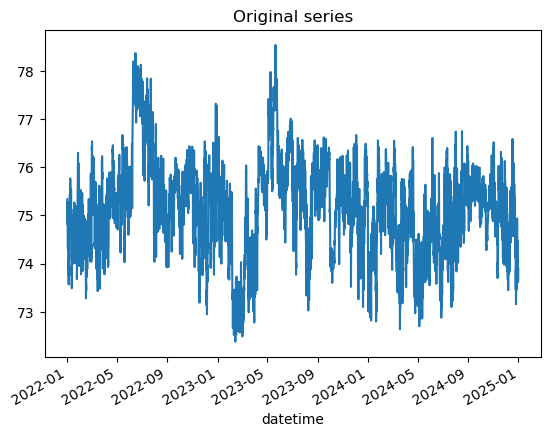

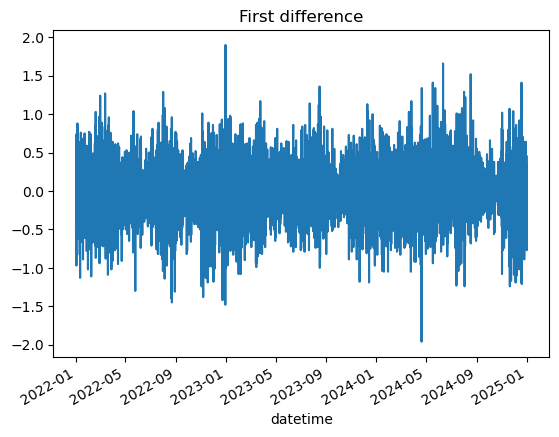

In [498]:
plt.figure()
h[col].plot(title="Original series")
plt.figure()
h[col].diff().dropna().plot(title="First difference")


**If the first-difference plot looks mean-reverting while the raw series drifts, you‚Äôve confirmed the unit root**

üîç What does mean-reverting look like?
A mean-reverting time series (Like the Difference Series!):

* Tends to return to a central level (mean or long-term average)

* Has fluctuations that ‚Äúbounce around‚Äù a stable band

* Doesn‚Äôt drift away indefinitely over time

In contrast, a non-mean-reverting (unit root or random walk) series (Like the Original Series!):

* Wanders freely

* Can trend upward or downward for long stretches

* Has a variance that grows over time

In [525]:
from statsmodels.tsa.stattools import adfuller
adf_stat, p, *_ = adfuller(h[col].dropna(), autolag="AIC")
print(f"ADF statistic = {adf_stat:.2f},  p-value = {p:.3f}")

ADF statistic = -5.09,  p-value = 0.000


* p < 0.05 ‚Üí reject unit root ‚Üí Œ≤ÃÇ should drop below 1 if you re-estimate.

* p ‚â• 0.05 ‚Üí cannot reject unit root ‚Üí difference the series.

In [505]:
# Re-estimate Œ≤ÃÇ on the differenced series:
h_diff = h[col].diff().dropna()
lag = 1

In [517]:
x = h_diff.shift(lag).rename("x")
y = h_diff.rename("y")
data = pd.concat([x, y], axis=1).dropna()

beta = np.linalg.lstsq(data[["x"]], data["y"], rcond=None)[0][0]
print(f"Œ≤ÃÇ on first difference = {beta:.3f}")


Œ≤ÃÇ on first difference = -0.226


We define the adjusted series
$$
\tilde{y}_t \;=\; y_t \;-\; \hat{\beta}\,y_{t-k}.
$$

$$
\tilde{\tilde{y}_t} \;=\; \tilde{y_t} \;+\; 0.226\,\tilde{y}_{t-1}.
$$

In [528]:
h_diff_adj = y - beta * x
h_diff_adj.name = f"{col}_adj"

In [538]:
len(h_diff_adj)

4382

In [540]:
len(df_merge.inflow_kcfs)

4383

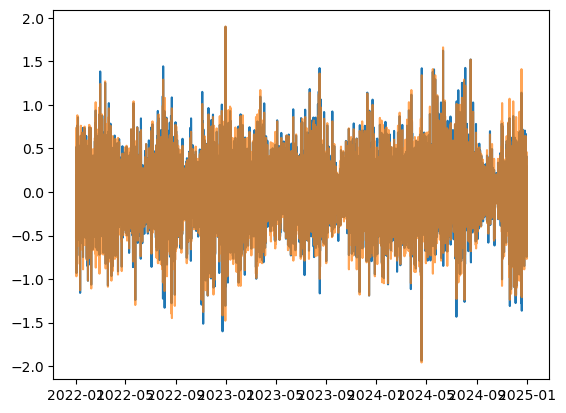

In [552]:
plt.plot(h_diff_adj)
plt.plot(h_adj, alpha = 0.7)

## LASSO Regression for Streamflow Rating

In [559]:
train_start_year = '2022'
test_start_year = '2024'

In [565]:
col

'inflow_ft'

In [581]:
df_reg = df_merge.copy()

In [585]:
def create_lags(df_reg, col, p):

    # Adding downstream lag features to the DataFrame
    for i in range(1, p):  # Creating lag features up to p time units
        df_reg[f'Y_Lag_{i}'] = df_reg[col].shift(i)

    # Drop rows with NaN values resulting from creating lag features
    df_reg.dropna(inplace=True)
    df_reg = df_reg.rename(columns={1: '1'})

    feature_cols = [col] + [f'Y_Lag_{lag}' for lag in range(1, p)]
    
    return df_reg, feature_cols

In [573]:
## Create lag features

p = 7 

df_reg, feature_cols = create_lags(df_reg, col, p)

In [595]:
feature_cols.append(col)

In [583]:
df_reg.head()

datetime  inflow_ft  inflow_kcfs  forebay_ft  Y_Lag_1  Y_Lag_2  \
6  2022-01-02 13:00:00      75.05      182.172        73.9    74.31    75.28   
7  2022-01-02 19:00:00      75.02      197.233        74.1    75.05    74.31   
8  2022-01-03 01:00:00      75.21      191.037        74.3    75.02    75.05   
9  2022-01-03 07:00:00      74.70      198.613        74.1    75.21    75.02   
10 2022-01-03 13:00:00      74.18      200.235        73.3    74.70    75.21   

    Y_Lag_3  Y_Lag_4  Y_Lag_5  Y_Lag_6  
6     75.11    75.13    74.82    75.34  
7     75.28    75.11    75.13    74.82  
8     74.31    75.28    75.11    75.13  
9     75.05    74.31    75.28    75.11  
10    75.02    75.05    74.31    75.28

In [599]:
## Split the data into training and testing sets

train_data = df_reg[(df_reg.datetime < test_start_year)]
test_data = df_reg[(df_reg.datetime >= test_start_year)]

X_train = train_data[feature_cols]
y_train = train_data['inflow_kcfs']

X_test = test_data[feature_cols]
y_test = test_data['inflow_kcfs']

In [603]:
X_train.head()

Y_Lag_1  Y_Lag_2  Y_Lag_3  Y_Lag_4  Y_Lag_5  Y_Lag_6  inflow_ft
6     74.31    75.28    75.11    75.13    74.82    75.34      75.05
7     75.05    74.31    75.28    75.11    75.13    74.82      75.02
8     75.02    75.05    74.31    75.28    75.11    75.13      75.21
9     75.21    75.02    75.05    74.31    75.28    75.11      74.70
10    74.70    75.21    75.02    75.05    74.31    75.28      74.18

In [605]:
lasso_train = X_train.copy() 
lasso_test = X_test.copy()

In [607]:
## Cross-Validation for Hyperparameter Finetuning

lasso_cv = LassoCV(cv=5, positive=True).fit(lasso_train, y_train)
alpha_star = lasso_cv.alpha_
print("Best alpha:", alpha_star)

Best alpha: 0.04392950329711304


In [609]:
## Create and fit LASSO model

#lasso = Lasso(alpha=0, positive=True)  # alpha is the regularization strength (higher = more shrinkage)
lasso = Lasso(alpha=alpha_star, positive=True)
lasso.fit(lasso_train, y_train)

Lasso(alpha=0.04392950329711304, positive=True)

In [611]:
## Make predictions

y_pred = pd.Series(lasso.predict(lasso_test))

In [613]:
## View coefficients

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lasso.coef_
})

# Optional: Sort by magnitude or filter out zeros
coef_df = coef_df[coef_df['coefficient'] != 0]  # remove zeroed-out features
coef_df = coef_df.sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df)

     feature  coefficient
6  inflow_ft    17.532006
5    Y_Lag_6    12.190507
0    Y_Lag_1     6.805059
2    Y_Lag_3     5.729247
4    Y_Lag_5     4.595878


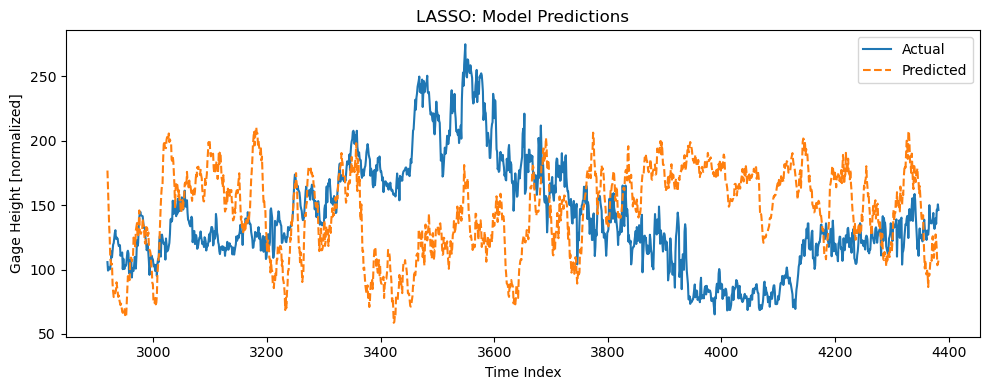

In [615]:
preproc.plot_forecasts("LASSO", y_test, y_pred)

In [617]:
preproc.print_test_stats(y_test, y_pred)

RMSE: 61.060
MAE: 50.931
R¬≤: -1.160
